# Notebook 2: Gymnasium Environment for Tracker Control

## RL-Based Single-Axis Solar Tracker Control

**Objective**: Build a complete Gymnasium environment for training RL agents

**Contents**:
1. Environment architecture overview
2. State space design
3. Action space design
4. Reward function implementation
5. Physics simulation (POA, shading, power)
6. Weather data integration
7. Episode management
8. Environment testing
9. Baseline policies for comparison

In [1]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dataclasses import dataclass, field
from typing import Optional, Tuple, Dict, Any, List
import warnings
warnings.filterwarnings('ignore')

# PVLib for solar physics
import pvlib
from pvlib import solarposition, irradiance, tracking, location, shading

# RL libraries
import gymnasium as gym
from gymnasium import spaces

print(f"Gymnasium version: {gym.__version__}")
print(f"PVLib version: {pvlib.__version__}")

Gymnasium version: 1.0.0
PVLib version: 0.13.0


## 1. Site Configuration (from Notebook 1)

In [2]:
@dataclass
class SiteConfig:
    """Configuration for a solar tracking installation."""
    
    # Location
    name: str = "Phoenix Solar Farm"
    latitude: float = 33.45
    longitude: float = -111.95
    altitude: float = 331
    timezone: str = "US/Arizona"
    
    # Tracker geometry
    gcr: float = 0.35
    axis_azimuth: float = 180
    max_angle: float = 60
    axis_height: float = 1.5
    collector_width: float = 2.2
    
    # Terrain
    terrain_slope: float = 0
    slope_azimuth: float = 180
    
    # System specs
    capacity_kw: float = 1000  # 1 MW for simulation
    module_efficiency: float = 0.20
    system_losses: float = 0.14  # 14% system losses (soiling, wiring, etc.)
    temp_coefficient: float = -0.004  # Power temp coefficient (%/°C)
    
    @property
    def row_pitch(self) -> float:
        return self.collector_width / self.gcr
    
    @property
    def array_area(self) -> float:
        """Total array area in m²."""
        return self.capacity_kw * 1000 / (1000 * self.module_efficiency)  # Assuming 1000 W/m² STC


# Default site
DEFAULT_SITE = SiteConfig()
print(f"Site: {DEFAULT_SITE.name}")
print(f"Capacity: {DEFAULT_SITE.capacity_kw} kW")
print(f"Array area: {DEFAULT_SITE.array_area:.0f} m²")
print(f"GCR: {DEFAULT_SITE.gcr}, Row pitch: {DEFAULT_SITE.row_pitch:.2f} m")

Site: Phoenix Solar Farm
Capacity: 1000 kW
Array area: 5000 m²
GCR: 0.35, Row pitch: 6.29 m


## 2. Weather Data Generator

We need weather data for training. Options:
1. **Clear sky** - Deterministic, good for initial testing
2. **Synthetic clouds** - Add realistic variability
3. **TMY data** - Real historical patterns (for later)

Let's build a flexible weather generator.

In [3]:
class WeatherGenerator:
    """
    Generate weather data for simulation.
    
    Supports:
    - Clear sky (deterministic baseline)
    - Synthetic clouds (stochastic)
    - Custom weather profiles
    """
    
    def __init__(self, site: SiteConfig, random_seed: Optional[int] = None):
        self.site = site
        self.location = location.Location(
            latitude=site.latitude,
            longitude=site.longitude,
            altitude=site.altitude,
            tz=site.timezone
        )
        self.rng = np.random.default_rng(random_seed)
    
    def get_clear_sky(self, times: pd.DatetimeIndex) -> pd.DataFrame:
        """Get clear sky irradiance."""
        clearsky = self.location.get_clearsky(times, model='ineichen')
        
        # Add temperature (simple model based on time of day)
        hour = times.hour + times.minute / 60
        # Temperature peaks around 3pm, min around 6am
        temp = 25 + 15 * np.sin((hour - 6) * np.pi / 12)
        temp = np.clip(temp, 10, 45)
        clearsky['temp_air'] = temp
        
        return clearsky
    
    def add_clouds(
        self, 
        clearsky: pd.DataFrame, 
        cloud_cover: float = 0.3,
        variability: float = 0.5
    ) -> pd.DataFrame:
        """
        Add synthetic cloud effects to clear sky data.
        
        Args:
            clearsky: Clear sky irradiance DataFrame
            cloud_cover: Mean cloud cover fraction (0-1)
            variability: How much clouds vary over time (0-1)
        
        Returns:
            DataFrame with cloudy irradiance
        """
        n = len(clearsky)
        
        # Generate correlated cloud cover using random walk
        # This creates realistic cloud passages
        noise = self.rng.normal(0, variability, n)
        cloud_factor = np.zeros(n)
        cloud_factor[0] = cloud_cover
        
        for i in range(1, n):
            # Mean-reverting random walk
            cloud_factor[i] = cloud_factor[i-1] + 0.1 * (cloud_cover - cloud_factor[i-1]) + 0.05 * noise[i]
        
        cloud_factor = np.clip(cloud_factor, 0, 1)
        
        # Apply cloud effects
        # Clouds reduce DNI more than DHI (diffuse increases relatively)
        cloudy = clearsky.copy()
        
        dni_factor = 1 - cloud_factor  # DNI drops with clouds
        dhi_factor = 1 + 0.3 * cloud_factor  # DHI increases slightly (more scattering)
        
        cloudy['dni'] = clearsky['dni'] * dni_factor
        cloudy['dhi'] = np.minimum(clearsky['dhi'] * dhi_factor, clearsky['ghi'])  # DHI can't exceed GHI
        cloudy['ghi'] = cloudy['dni'] * np.cos(np.radians(90 - self._get_elevation(clearsky.index))) + cloudy['dhi']
        cloudy['ghi'] = np.maximum(cloudy['ghi'], 0)
        
        # Store cloud cover for state
        cloudy['cloud_cover'] = cloud_factor
        
        return cloudy
    
    def _get_elevation(self, times: pd.DatetimeIndex) -> np.ndarray:
        """Get solar elevation for times."""
        solar_pos = solarposition.get_solarposition(
            times, self.site.latitude, self.site.longitude, self.site.altitude
        )
        return solar_pos['apparent_elevation'].values
    
    def generate_day(
        self, 
        date: pd.Timestamp,
        freq: str = '5min',
        weather_type: str = 'clear',
        cloud_cover: float = 0.3
    ) -> pd.DataFrame:
        """
        Generate a full day of weather data.
        
        Args:
            date: Date to generate
            freq: Time resolution
            weather_type: 'clear', 'partly_cloudy', 'cloudy', 'variable'
            cloud_cover: Cloud cover for non-clear types
        """
        # Create time index for full day
        if date.tzinfo is None:
            date = date.tz_localize(self.site.timezone)
        
        times = pd.date_range(
            start=date.normalize(),
            end=date.normalize() + timedelta(days=1) - timedelta(minutes=1),
            freq=freq
        )
        
        # Get clear sky baseline
        weather = self.get_clear_sky(times)
        weather['cloud_cover'] = 0.0
        
        # Apply weather type
        if weather_type == 'clear':
            pass  # Already clear
        elif weather_type == 'partly_cloudy':
            weather = self.add_clouds(weather, cloud_cover=0.3, variability=0.3)
        elif weather_type == 'cloudy':
            weather = self.add_clouds(weather, cloud_cover=0.7, variability=0.2)
        elif weather_type == 'variable':
            weather = self.add_clouds(weather, cloud_cover=0.5, variability=0.8)
        else:
            weather = self.add_clouds(weather, cloud_cover=cloud_cover, variability=0.4)
        
        return weather


# Test weather generator
weather_gen = WeatherGenerator(DEFAULT_SITE, random_seed=42)
test_date = pd.Timestamp('2024-06-21', tz=DEFAULT_SITE.timezone)

# Generate different weather types
weather_clear = weather_gen.generate_day(test_date, weather_type='clear')
weather_cloudy = weather_gen.generate_day(test_date, weather_type='variable')

print(f"Generated {len(weather_clear)} timesteps")
print(f"Clear sky peak GHI: {weather_clear['ghi'].max():.0f} W/m²")
print(f"Variable sky peak GHI: {weather_cloudy['ghi'].max():.0f} W/m²")

Generated 288 timesteps
Clear sky peak GHI: 1003 W/m²
Variable sky peak GHI: 681 W/m²


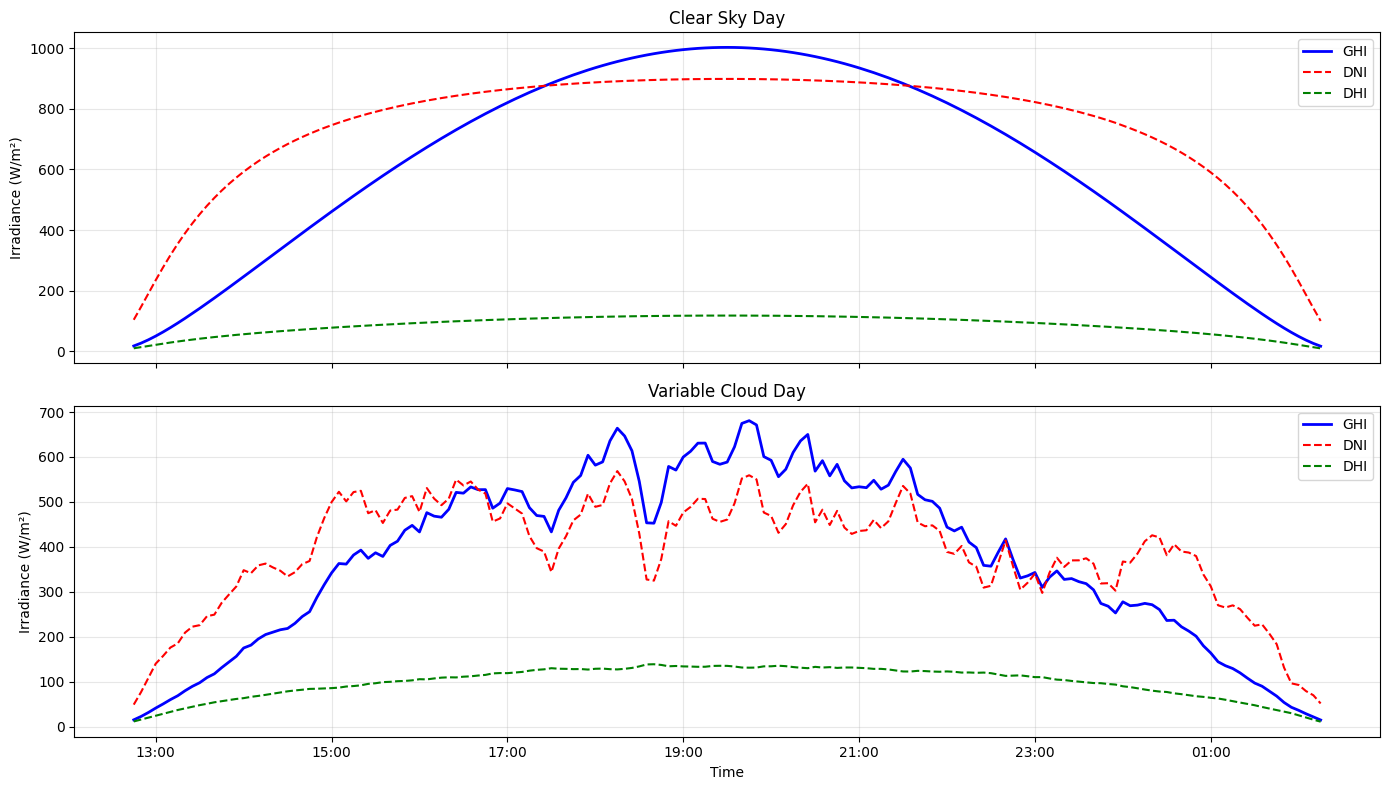

In [4]:
# Visualize weather types
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Filter to daylight
daylight_clear = weather_clear[weather_clear['ghi'] > 10]
daylight_cloudy = weather_cloudy[weather_cloudy['ghi'] > 10]

ax1 = axes[0]
ax1.plot(daylight_clear.index, daylight_clear['ghi'], 'b-', label='GHI', linewidth=2)
ax1.plot(daylight_clear.index, daylight_clear['dni'], 'r--', label='DNI', linewidth=1.5)
ax1.plot(daylight_clear.index, daylight_clear['dhi'], 'g--', label='DHI', linewidth=1.5)
ax1.set_ylabel('Irradiance (W/m²)')
ax1.set_title('Clear Sky Day')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.plot(daylight_cloudy.index, daylight_cloudy['ghi'], 'b-', label='GHI', linewidth=2)
ax2.plot(daylight_cloudy.index, daylight_cloudy['dni'], 'r--', label='DNI', linewidth=1.5)
ax2.plot(daylight_cloudy.index, daylight_cloudy['dhi'], 'g--', label='DHI', linewidth=1.5)
ax2.set_xlabel('Time')
ax2.set_ylabel('Irradiance (W/m²)')
ax2.set_title('Variable Cloud Day')
ax2.legend()
ax2.grid(True, alpha=0.3)

import matplotlib.dates as mdates
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.tight_layout()
plt.show()

## 3. Power Model

Convert POA irradiance to DC power output, accounting for:
- Module efficiency
- Temperature effects
- System losses
- Inter-row shading

In [5]:
class PowerModel:
    """
    Calculate power output from POA irradiance.
    """
    
    def __init__(self, site: SiteConfig):
        self.site = site
    
    def calculate_power(
        self,
        poa_global: float,
        temp_air: float,
        shading_fraction: float = 0.0
    ) -> float:
        """
        Calculate DC power output.
        
        Args:
            poa_global: Plane-of-array global irradiance (W/m²)
            temp_air: Ambient temperature (°C)
            shading_fraction: Fraction of array shaded (0-1)
        
        Returns:
            DC power in kW
        """
        if poa_global <= 0:
            return 0.0
        
        # Estimate cell temperature (simple model)
        # Cell temp is typically 25-35°C above ambient under full sun
        temp_cell = temp_air + 0.03 * poa_global  # ~30°C rise at 1000 W/m²
        
        # Temperature derating (relative to 25°C STC)
        temp_factor = 1 + self.site.temp_coefficient * (temp_cell - 25)
        temp_factor = max(0.5, min(1.1, temp_factor))  # Reasonable bounds
        
        # Effective irradiance after shading
        effective_poa = poa_global * (1 - shading_fraction)
        
        # Power calculation
        # P = POA * Area * Efficiency * TempFactor * (1 - Losses)
        power_kw = (
            effective_poa / 1000  # Convert W/m² to kW/m²
            * self.site.array_area
            * self.site.module_efficiency
            * temp_factor
            * (1 - self.site.system_losses)
        )
        
        # Can't exceed nameplate capacity
        power_kw = min(power_kw, self.site.capacity_kw)
        
        return max(0.0, power_kw)


# Test power model
power_model = PowerModel(DEFAULT_SITE)

test_cases = [
    (1000, 25, 0.0),   # STC conditions, no shading
    (1000, 40, 0.0),   # Hot day
    (1000, 25, 0.5),   # 50% shading
    (500, 25, 0.0),    # Morning/evening
    (100, 25, 0.0),    # Low light
]

print("Power Model Test:")
print(f"{'POA (W/m²)':>12} {'Temp (°C)':>10} {'Shading':>10} {'Power (kW)':>12} {'Capacity %':>12}")
print("-" * 60)
for poa, temp, shade in test_cases:
    power = power_model.calculate_power(poa, temp, shade)
    pct = power / DEFAULT_SITE.capacity_kw * 100
    print(f"{poa:>12} {temp:>10} {shade:>10.1%} {power:>12.1f} {pct:>11.1f}%")

Power Model Test:
  POA (W/m²)  Temp (°C)    Shading   Power (kW)   Capacity %
------------------------------------------------------------
        1000         25       0.0%        756.8        75.7%
        1000         40       0.0%        705.2        70.5%
        1000         25      50.0%        378.4        37.8%
         500         25       0.0%        404.2        40.4%
         100         25       0.0%         85.0         8.5%


## 4. Tracker Environment

Now we build the complete Gymnasium environment.

In [6]:
class TrackerEnv(gym.Env):
    """
    Gymnasium environment for single-axis solar tracker control.
    
    State space:
        - Solar elevation (normalized)
        - Solar azimuth (sin/cos encoded)
        - GHI, DNI, DHI (normalized)
        - Diffuse fraction
        - Current tracker angle (normalized)
        - Temperature (normalized)
        - Cloud cover (if available)
    
    Action space:
        - Continuous tracker angle [-60°, +60°]
    
    Reward:
        - Energy harvested in timestep (kWh)
        - Optional penalty for excessive movement
    """
    
    metadata = {'render_modes': ['human', 'rgb_array']}
    
    def __init__(
        self,
        site: Optional[SiteConfig] = None,
        weather_type: str = 'clear',
        episode_type: str = 'day',  # 'day' or 'year'
        timestep_minutes: int = 5,
        random_seed: Optional[int] = None,
        movement_penalty: float = 0.0,  # Penalty per degree of movement
        normalize_reward: bool = True,
    ):
        super().__init__()
        
        self.site = site or SiteConfig()
        self.weather_type = weather_type
        self.episode_type = episode_type
        self.timestep_minutes = timestep_minutes
        self.timestep_hours = timestep_minutes / 60
        self.movement_penalty = movement_penalty
        self.normalize_reward = normalize_reward
        
        # Initialize components
        self.weather_gen = WeatherGenerator(self.site, random_seed)
        self.power_model = PowerModel(self.site)
        self.rng = np.random.default_rng(random_seed)
        
        # State dimension: 11 features
        # [elev, azim_sin, azim_cos, ghi, dni, dhi, diffuse_frac, 
        #  current_angle, temp, cloud_cover, hour_sin, hour_cos]
        self.state_dim = 12
        
        # Define spaces
        self.observation_space = spaces.Box(
            low=-1.0, high=1.0, shape=(self.state_dim,), dtype=np.float32
        )
        
        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=(1,), dtype=np.float32
        )  # Will be scaled to [-max_angle, +max_angle]
        
        # Episode state
        self.weather_data = None
        self.solar_pos = None
        self.current_step = 0
        self.current_angle = 0.0
        self.episode_reward = 0.0
        self.episode_energy = 0.0
        
        # For tracking history
        self.history = []
    
    def _get_solar_position(self, times: pd.DatetimeIndex) -> pd.DataFrame:
        """Calculate solar position."""
        return solarposition.get_solarposition(
            times, self.site.latitude, self.site.longitude, self.site.altitude
        )
    
    def _calculate_poa(
        self, 
        tracker_angle: float,
        solar_zenith: float,
        solar_azimuth: float,
        dni: float,
        ghi: float,
        dhi: float
    ) -> float:
        """Calculate POA irradiance for given tracker angle."""
        if solar_zenith >= 90 or ghi <= 0:
            return 0.0
        
        # Use PVLib to get proper surface orientation for this tracker angle
        # For horizontal single-axis tracker:
        # - surface_tilt = |tracker_angle|
        # - surface_azimuth = axis_azimuth + sign(tracker_angle) * 90
        #   (negative angle = east-facing, positive = west-facing for N-S axis)
        
        surface_tilt = abs(tracker_angle)
        if tracker_angle > 0:
            surface_azimuth = self.site.axis_azimuth + 90  # West for positive angle
        elif tracker_angle < 0:
            surface_azimuth = self.site.axis_azimuth - 90  # East for negative angle
        else:
            surface_azimuth = self.site.axis_azimuth  # Horizontal, azimuth doesn't matter
        
        # Normalize azimuth to 0-360
        surface_azimuth = surface_azimuth % 360
        
        # Get extraterrestrial radiation and airmass
        dni_extra = irradiance.get_extra_radiation(self.current_time)
        airmass = pvlib.atmosphere.get_relative_airmass(solar_zenith)
        
        try:
            poa = irradiance.get_total_irradiance(
                surface_tilt=surface_tilt,
                surface_azimuth=surface_azimuth,
                solar_zenith=solar_zenith,
                solar_azimuth=solar_azimuth,
                dni=dni,
                ghi=ghi,
                dhi=dhi,
                dni_extra=dni_extra,
                airmass=airmass,
                model='perez'
            )
            return max(0.0, float(poa['poa_global']))
        except Exception as e:
            # Fallback to isotropic model if Perez fails
            try:
                poa = irradiance.get_total_irradiance(
                    surface_tilt=surface_tilt,
                    surface_azimuth=surface_azimuth,
                    solar_zenith=solar_zenith,
                    solar_azimuth=solar_azimuth,
                    dni=dni,
                    ghi=ghi,
                    dhi=dhi,
                    model='isotropic'
                )
                return max(0.0, float(poa['poa_global']))
            except:
                # Last resort: estimate based on cosine of incidence angle
                cos_aoi = np.cos(np.radians(solar_zenith)) * np.cos(np.radians(surface_tilt)) + \
                          np.sin(np.radians(solar_zenith)) * np.sin(np.radians(surface_tilt)) * \
                          np.cos(np.radians(solar_azimuth - surface_azimuth))
                cos_aoi = max(0, cos_aoi)
                return dni * cos_aoi + dhi
    
    def _calculate_shading(self, tracker_angle: float) -> float:
        """Calculate shading fraction using PVLib."""
        solar_zenith = self.solar_pos.loc[self.current_time, 'apparent_zenith']
        solar_azimuth = self.solar_pos.loc[self.current_time, 'azimuth']
        
        if solar_zenith >= 90:
            return 1.0
        
        try:
            shaded = shading.shaded_fraction1d(
                solar_zenith=solar_zenith,
                solar_azimuth=solar_azimuth,
                axis_azimuth=self.site.axis_azimuth,
                shaded_row_rotation=tracker_angle,
                collector_width=self.site.collector_width,
                pitch=self.site.row_pitch,
                axis_tilt=0,
                cross_axis_slope=self.site.terrain_slope
            )
            return float(shaded)
        except:
            return 0.0
    
    def _get_state(self) -> np.ndarray:
        """Construct state vector from current conditions."""
        weather = self.weather_data.loc[self.current_time]
        solar = self.solar_pos.loc[self.current_time]
        
        # Normalize features to [-1, 1] or [0, 1]
        elevation = solar['apparent_elevation'] / 90.0  # [0, 1]
        azimuth_rad = np.radians(solar['azimuth'])
        azimuth_sin = np.sin(azimuth_rad)  # [-1, 1]
        azimuth_cos = np.cos(azimuth_rad)  # [-1, 1]
        
        ghi_norm = weather['ghi'] / 1200.0  # Normalize by ~max GHI
        dni_norm = weather['dni'] / 1000.0
        dhi_norm = weather['dhi'] / 300.0
        
        # Diffuse fraction (important for deciding tracking strategy)
        diffuse_frac = weather['dhi'] / max(weather['ghi'], 1) 
        diffuse_frac = min(1.0, diffuse_frac)
        
        # Current tracker angle normalized
        angle_norm = self.current_angle / self.site.max_angle  # [-1, 1]
        
        # Temperature normalized
        temp_norm = (weather['temp_air'] - 25) / 25  # Centered on 25°C
        
        # Cloud cover (if available)
        cloud_cover = weather.get('cloud_cover', 0.0)
        
        # Hour encoding
        hour = self.current_time.hour + self.current_time.minute / 60
        hour_sin = np.sin(2 * np.pi * hour / 24)
        hour_cos = np.cos(2 * np.pi * hour / 24)
        
        state = np.array([
            elevation,
            azimuth_sin,
            azimuth_cos,
            ghi_norm,
            dni_norm,
            dhi_norm,
            diffuse_frac,
            angle_norm,
            temp_norm,
            cloud_cover,
            hour_sin,
            hour_cos
        ], dtype=np.float32)
        
        # Clip to observation space bounds
        state = np.clip(state, -1.0, 1.0)
        
        return state
    
    def _get_info(self) -> Dict[str, Any]:
        """Get info dict with useful debugging info."""
        weather = self.weather_data.loc[self.current_time]
        solar = self.solar_pos.loc[self.current_time]
        
        return {
            'time': self.current_time,
            'solar_elevation': solar['apparent_elevation'],
            'solar_azimuth': solar['azimuth'],
            'ghi': weather['ghi'],
            'dni': weather['dni'],
            'dhi': weather['dhi'],
            'tracker_angle': self.current_angle,
            'episode_energy': self.episode_energy,
        }
    
    def reset(
        self, 
        seed: Optional[int] = None,
        options: Optional[Dict] = None
    ) -> Tuple[np.ndarray, Dict]:
        """Reset environment for new episode."""
        super().reset(seed=seed)
        
        if seed is not None:
            self.rng = np.random.default_rng(seed)
            self.weather_gen = WeatherGenerator(self.site, seed)
        
        # Choose episode date
        if options and 'date' in options:
            date = pd.Timestamp(options['date'], tz=self.site.timezone)
        else:
            # Random date in year
            day_of_year = self.rng.integers(1, 366)
            date = pd.Timestamp('2024-01-01', tz=self.site.timezone) + timedelta(days=int(day_of_year) - 1)
        
        # Weather type for episode
        weather_type = self.weather_type
        if options and 'weather_type' in options:
            weather_type = options['weather_type']
        elif self.weather_type == 'random':
            weather_type = self.rng.choice(['clear', 'partly_cloudy', 'cloudy', 'variable'])
        
        # Generate weather data
        self.weather_data = self.weather_gen.generate_day(
            date, 
            freq=f'{self.timestep_minutes}min',
            weather_type=weather_type
        )
        
        # Calculate solar position for all times
        self.solar_pos = self._get_solar_position(self.weather_data.index)
        
        # Find daylight hours (elevation > 0)
        daylight_mask = self.solar_pos['apparent_elevation'] > 0
        self.daylight_times = self.weather_data.index[daylight_mask]
        
        if len(self.daylight_times) == 0:
            # Fallback if no daylight (shouldn't happen)
            self.daylight_times = self.weather_data.index
        
        # Initialize episode
        self.current_step = 0
        self.current_time = self.daylight_times[0]
        self.current_angle = 0.0  # Start horizontal
        self.episode_reward = 0.0
        self.episode_energy = 0.0
        self.history = []
        
        return self._get_state(), self._get_info()
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        """Execute one timestep."""
        # Convert action to tracker angle
        action_value = float(action[0]) if isinstance(action, np.ndarray) else float(action)
        new_angle = action_value * self.site.max_angle  # Scale to [-60, 60]
        new_angle = np.clip(new_angle, -self.site.max_angle, self.site.max_angle)
        
        # Calculate movement penalty
        angle_change = abs(new_angle - self.current_angle)
        movement_cost = self.movement_penalty * angle_change
        
        # Update tracker angle
        prev_angle = self.current_angle
        self.current_angle = new_angle
        
        # Get current conditions
        weather = self.weather_data.loc[self.current_time]
        solar = self.solar_pos.loc[self.current_time]
        
        # Calculate POA irradiance
        poa = self._calculate_poa(
            self.current_angle,
            solar['apparent_zenith'],
            solar['azimuth'],
            weather['dni'],
            weather['ghi'],
            weather['dhi']
        )
        
        # Calculate shading
        shading_frac = self._calculate_shading(self.current_angle)
        
        # Calculate power
        power_kw = self.power_model.calculate_power(
            poa, weather['temp_air'], shading_frac
        )
        
        # Energy harvested this timestep (kWh)
        energy_kwh = power_kw * self.timestep_hours
        
        # Calculate reward
        if self.normalize_reward:
            # Normalize by theoretical max energy
            max_energy = self.site.capacity_kw * self.timestep_hours
            reward = energy_kwh / max_energy - movement_cost / max_energy
        else:
            reward = energy_kwh - movement_cost
        
        # Update episode stats
        self.episode_reward += reward
        self.episode_energy += energy_kwh
        
        # Store history
        self.history.append({
            'time': self.current_time,
            'angle': self.current_angle,
            'poa': poa,
            'shading': shading_frac,
            'power_kw': power_kw,
            'energy_kwh': energy_kwh,
            'reward': reward,
            'ghi': weather['ghi'],
            'dni': weather['dni'],
        })
        
        # Advance time
        self.current_step += 1
        
        # Check if episode done
        terminated = self.current_step >= len(self.daylight_times)
        truncated = False
        
        if not terminated:
            self.current_time = self.daylight_times[self.current_step]
        
        # Get new state
        if terminated:
            state = self._get_state()  # Return last valid state
        else:
            state = self._get_state()
        
        info = self._get_info()
        info['power_kw'] = power_kw
        info['energy_kwh'] = energy_kwh
        info['shading'] = shading_frac
        info['poa'] = poa
        
        return state, reward, terminated, truncated, info
    
    def get_history_df(self) -> pd.DataFrame:
        """Return episode history as DataFrame."""
        return pd.DataFrame(self.history)


print("TrackerEnv defined successfully!")

TrackerEnv defined successfully!


## 5. Test the Environment

In [7]:
# Create environment
env = TrackerEnv(
    site=DEFAULT_SITE,
    weather_type='clear',
    timestep_minutes=5,
    random_seed=42
)

# Test reset
state, info = env.reset(options={'date': '2024-06-21'})

print(f"Environment created!")
print(f"State shape: {state.shape}")
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
print(f"\nInitial state: {state.round(3)}")
print(f"\nInitial info: {info}")
print(f"\nDaylight hours: {len(env.daylight_times)} timesteps ({len(env.daylight_times) * 5 / 60:.1f} hours)")

Environment created!
State shape: (12,)
Action space: Box(-1.0, 1.0, (1,), float32)
Observation space: Box(-1.0, 1.0, (12,), float32)

Initial state: [ 0.008  0.881  0.473  0.     0.004  0.001  0.267  0.    -0.091  0.
  0.988  0.152]

Initial info: {'time': Timestamp('2024-06-21 05:25:00-0700', tz='US/Arizona'), 'solar_elevation': 0.7542267807476131, 'solar_azimuth': 61.78351998133553, 'ghi': 0.313146905030849, 'dni': 3.5283228978202463, 'dhi': 0.26670231892060975, 'tracker_angle': 0.0, 'episode_energy': 0.0}

Daylight hours: 171 timesteps (14.2 hours)


In [8]:
# Run a single step
action = np.array([0.5])  # 0.5 * 60° = 30°
next_state, reward, terminated, truncated, info = env.step(action)

print(f"Action: {action[0]:.2f} → Tracker angle: {info['tracker_angle']:.1f}°")
print(f"Reward: {reward:.4f}")
print(f"Power: {info['power_kw']:.1f} kW")
print(f"POA: {info['poa']:.1f} W/m²")
print(f"Shading: {info['shading']*100:.1f}%")
print(f"Terminated: {terminated}")

Action: 0.50 → Tracker angle: 30.0°
Reward: 0.0000
Power: 0.0 kW
POA: 0.2 W/m²
Shading: 91.2%
Terminated: False


## 6. Baseline Policies

Implement baseline policies to compare against RL:
1. **Fixed horizontal** - Always at 0°
2. **Geometric backtracking** - PVLib standard
3. **True tracking** - Point at sun (no backtracking)
4. **Random** - Random actions

In [9]:
class BaselinePolicy:
    """Base class for baseline policies."""
    
    def __init__(self, site: SiteConfig):
        self.site = site
    
    def get_action(self, state: np.ndarray, info: Dict) -> np.ndarray:
        """Return action given state."""
        raise NotImplementedError
    
    def get_angle(self, state: np.ndarray, info: Dict) -> float:
        """Return tracker angle in degrees."""
        action = self.get_action(state, info)
        return action[0] * self.site.max_angle


class FixedHorizontalPolicy(BaselinePolicy):
    """Always stay horizontal (0°)."""
    
    def get_action(self, state: np.ndarray, info: Dict) -> np.ndarray:
        return np.array([0.0])


class GeometricBacktrackingPolicy(BaselinePolicy):
    """Use PVLib geometric backtracking."""
    
    def get_action(self, state: np.ndarray, info: Dict) -> np.ndarray:
        solar_zenith = 90 - info['solar_elevation']
        solar_azimuth = info['solar_azimuth']
        
        if info['solar_elevation'] <= 0:
            return np.array([0.0])
        
        # Use PVLib singleaxis tracking
        tracking_data = tracking.singleaxis(
            apparent_zenith=solar_zenith,
            apparent_azimuth=solar_azimuth,
            axis_tilt=0,
            axis_azimuth=self.site.axis_azimuth,
            max_angle=self.site.max_angle,
            backtrack=True,
            gcr=self.site.gcr
        )
        
        angle = tracking_data['tracker_theta']
        if pd.isna(angle):
            return np.array([0.0])
        
        # Normalize to [-1, 1]
        return np.array([angle / self.site.max_angle])


class TrueTrackingPolicy(BaselinePolicy):
    """Track sun directly without backtracking."""
    
    def get_action(self, state: np.ndarray, info: Dict) -> np.ndarray:
        solar_zenith = 90 - info['solar_elevation']
        solar_azimuth = info['solar_azimuth']
        
        if info['solar_elevation'] <= 0:
            return np.array([0.0])
        
        # Use PVLib without backtracking
        tracking_data = tracking.singleaxis(
            apparent_zenith=solar_zenith,
            apparent_azimuth=solar_azimuth,
            axis_tilt=0,
            axis_azimuth=self.site.axis_azimuth,
            max_angle=self.site.max_angle,
            backtrack=False,
            gcr=self.site.gcr
        )
        
        angle = tracking_data['tracker_theta']
        if pd.isna(angle):
            return np.array([0.0])
        
        return np.array([angle / self.site.max_angle])


class RandomPolicy(BaselinePolicy):
    """Random actions."""
    
    def __init__(self, site: SiteConfig, seed: Optional[int] = None):
        super().__init__(site)
        self.rng = np.random.default_rng(seed)
    
    def get_action(self, state: np.ndarray, info: Dict) -> np.ndarray:
        return self.rng.uniform(-1, 1, size=(1,)).astype(np.float32)


print("Baseline policies defined!")

Baseline policies defined!


In [10]:
def run_episode(env: TrackerEnv, policy: BaselinePolicy, verbose: bool = False) -> Dict:
    """
    Run a single episode with given policy.
    
    Returns dict with episode stats.
    """
    state, info = env.reset()
    
    total_reward = 0
    total_energy = 0
    steps = 0
    
    while True:
        action = policy.get_action(state, info)
        state, reward, terminated, truncated, info = env.step(action)
        
        total_reward += reward
        total_energy += info['energy_kwh']
        steps += 1
        
        if verbose and steps % 50 == 0:
            print(f"Step {steps}: angle={info['tracker_angle']:.1f}°, power={info['power_kw']:.1f}kW")
        
        if terminated or truncated:
            break
    
    return {
        'total_reward': total_reward,
        'total_energy_kwh': total_energy,
        'steps': steps,
        'history': env.get_history_df()
    }


# Test run with backtracking policy
env = TrackerEnv(site=DEFAULT_SITE, weather_type='clear', random_seed=42)
policy = GeometricBacktrackingPolicy(DEFAULT_SITE)

result = run_episode(env, policy, verbose=True)
print(f"\n📊 Episode Summary:")
print(f"   Total energy: {result['total_energy_kwh']:.1f} kWh")
print(f"   Total reward: {result['total_reward']:.2f}")
print(f"   Steps: {result['steps']}")

Step 50: angle=-26.0°, power=527.8kW
Step 100: angle=58.6°, power=586.1kW

📊 Episode Summary:
   Total energy: 4791.3 kWh
   Total reward: 57.50
   Steps: 127


## 7. Compare Baseline Policies

In [11]:
def compare_policies(
    site: SiteConfig,
    policies: Dict[str, BaselinePolicy],
    weather_type: str = 'clear',
    date: str = '2024-06-21',
    seed: int = 42
) -> pd.DataFrame:
    """
    Compare multiple policies on same day.
    """
    results = []
    histories = {}
    
    for name, policy in policies.items():
        env = TrackerEnv(
            site=site, 
            weather_type=weather_type, 
            random_seed=seed
        )
        env.reset(options={'date': date})
        
        result = run_episode(env, policy)
        
        results.append({
            'policy': name,
            'energy_kwh': result['total_energy_kwh'],
            'reward': result['total_reward'],
            'steps': result['steps']
        })
        
        histories[name] = result['history']
    
    return pd.DataFrame(results), histories


# Define policies to compare
policies = {
    'Fixed Horizontal': FixedHorizontalPolicy(DEFAULT_SITE),
    'True Tracking': TrueTrackingPolicy(DEFAULT_SITE),
    'Geometric Backtracking': GeometricBacktrackingPolicy(DEFAULT_SITE),
    'Random': RandomPolicy(DEFAULT_SITE, seed=123),
}

# Compare on clear sky day
print("Comparing policies on CLEAR SKY day (Summer Solstice)...")
results_clear, histories_clear = compare_policies(
    DEFAULT_SITE, policies, 
    weather_type='clear', 
    date='2024-06-21'
)

print("\n📊 Clear Sky Results:")
print(results_clear.to_string(index=False))

# Calculate relative performance
baseline_energy = results_clear[results_clear['policy'] == 'Geometric Backtracking']['energy_kwh'].values[0]
results_clear['vs_backtracking'] = (results_clear['energy_kwh'] / baseline_energy - 1) * 100
print("\n📊 Performance vs Geometric Backtracking:")
print(results_clear[['policy', 'energy_kwh', 'vs_backtracking']].to_string(index=False))

Comparing policies on CLEAR SKY day (Summer Solstice)...

📊 Clear Sky Results:
                policy  energy_kwh    reward  steps
      Fixed Horizontal 3295.625825 39.547510    127
         True Tracking 4774.770015 57.297240    127
Geometric Backtracking 4791.288763 57.495465    127
                Random 3005.847639 36.070172    127

📊 Performance vs Geometric Backtracking:
                policy  energy_kwh  vs_backtracking
      Fixed Horizontal 3295.625825       -31.216297
         True Tracking 4774.770015        -0.344766
Geometric Backtracking 4791.288763         0.000000
                Random 3005.847639       -37.264319


In [12]:
# Compare on cloudy day
print("\nComparing policies on VARIABLE CLOUD day...")
results_cloudy, histories_cloudy = compare_policies(
    DEFAULT_SITE, policies, 
    weather_type='variable', 
    date='2024-06-21'
)

print("\n📊 Variable Cloud Results:")
baseline_energy_cloudy = results_cloudy[results_cloudy['policy'] == 'Geometric Backtracking']['energy_kwh'].values[0]
results_cloudy['vs_backtracking'] = (results_cloudy['energy_kwh'] / baseline_energy_cloudy - 1) * 100
print(results_cloudy[['policy', 'energy_kwh', 'vs_backtracking']].to_string(index=False))


Comparing policies on VARIABLE CLOUD day...

📊 Variable Cloud Results:
                policy  energy_kwh  vs_backtracking
      Fixed Horizontal 1952.286795       -31.343470
         True Tracking 2834.179275        -0.329750
Geometric Backtracking 2843.555887         0.000000
                Random 1917.345171       -32.572271


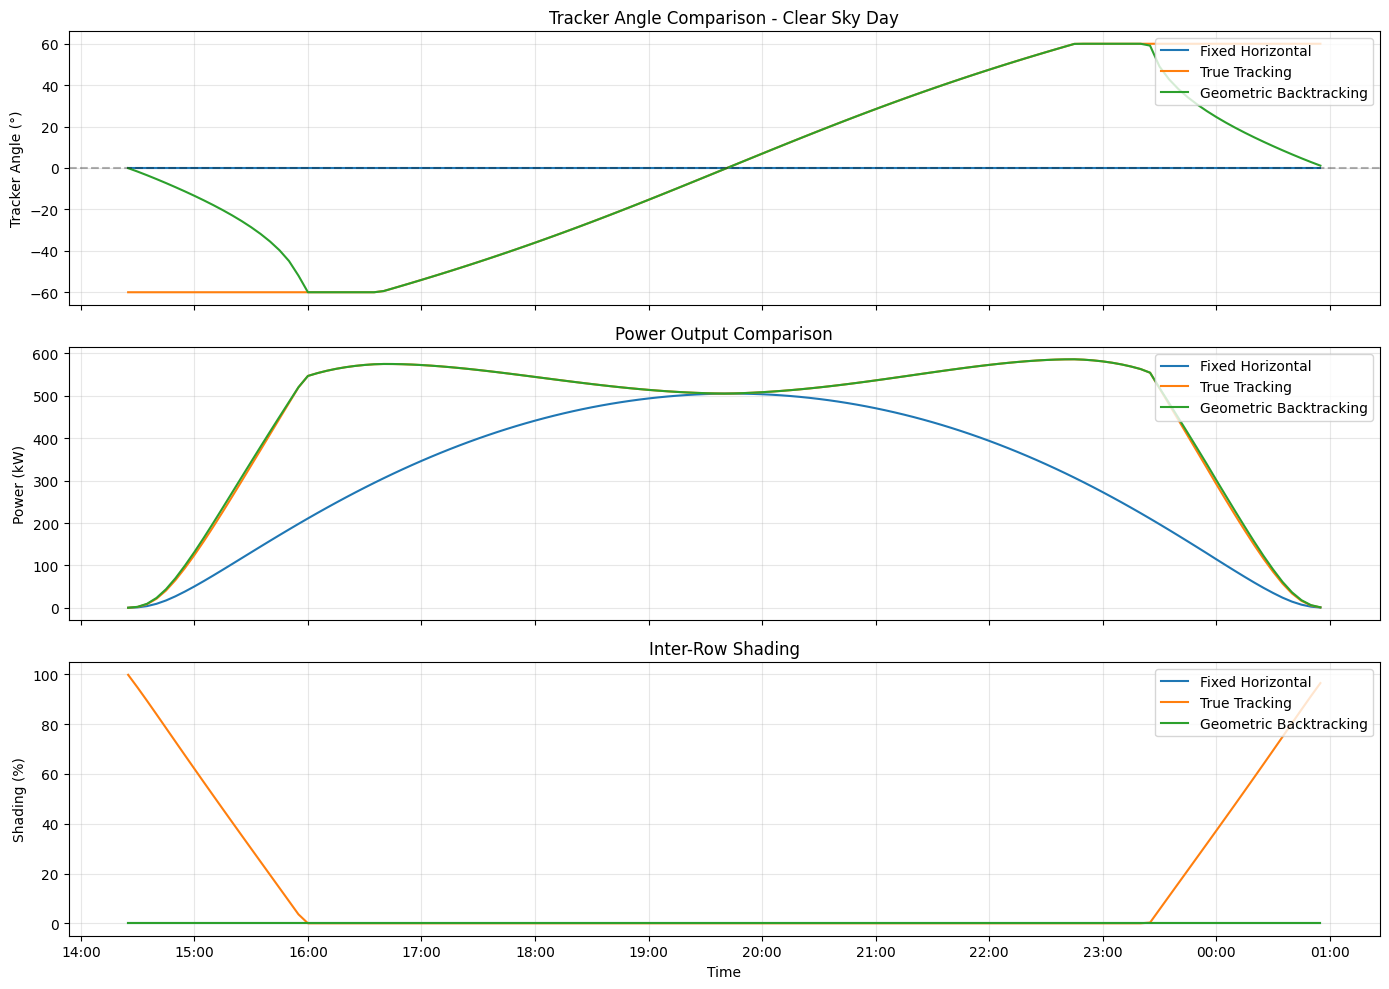

In [13]:
# Visualize policy behavior
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Plot for clear sky day
ax1 = axes[0]
for name, history in histories_clear.items():
    if name != 'Random':  # Skip random for clarity
        ax1.plot(history['time'], history['angle'], label=name, linewidth=1.5)
ax1.set_ylabel('Tracker Angle (°)')
ax1.set_title('Tracker Angle Comparison - Clear Sky Day')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Power output
ax2 = axes[1]
for name, history in histories_clear.items():
    if name != 'Random':
        ax2.plot(history['time'], history['power_kw'], label=name, linewidth=1.5)
ax2.set_ylabel('Power (kW)')
ax2.set_title('Power Output Comparison')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Shading
ax3 = axes[2]
for name, history in histories_clear.items():
    if name != 'Random':
        ax3.plot(history['time'], history['shading'] * 100, label=name, linewidth=1.5)
ax3.set_xlabel('Time')
ax3.set_ylabel('Shading (%)')
ax3.set_title('Inter-Row Shading')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.tight_layout()
plt.show()

## 8. Multi-Day Comparison

In [14]:
def run_multi_day_comparison(
    site: SiteConfig,
    policies: Dict[str, BaselinePolicy],
    n_days: int = 30,
    weather_types: List[str] = ['clear', 'partly_cloudy', 'variable', 'cloudy'],
    seed: int = 42
) -> pd.DataFrame:
    """
    Run comparison across multiple days with varied weather.
    """
    rng = np.random.default_rng(seed)
    all_results = []
    
    for day in range(n_days):
        # Random date and weather
        day_of_year = rng.integers(1, 366)
        date = (pd.Timestamp('2024-01-01') + timedelta(days=int(day_of_year) - 1)).strftime('%Y-%m-%d')
        weather_type = rng.choice(weather_types)
        
        for name, policy in policies.items():
            env = TrackerEnv(
                site=site, 
                weather_type=weather_type, 
                random_seed=seed + day
            )
            env.reset(options={'date': date})
            
            result = run_episode(env, policy)
            
            all_results.append({
                'day': day,
                'date': date,
                'weather': weather_type,
                'policy': name,
                'energy_kwh': result['total_energy_kwh']
            })
    
    return pd.DataFrame(all_results)


# Run multi-day comparison
print("Running 30-day comparison (this may take a minute)...")
multi_day_results = run_multi_day_comparison(
    DEFAULT_SITE,
    {
        'Fixed': FixedHorizontalPolicy(DEFAULT_SITE),
        'True Track': TrueTrackingPolicy(DEFAULT_SITE),
        'Backtrack': GeometricBacktrackingPolicy(DEFAULT_SITE),
    },
    n_days=30,
    seed=42
)

print("Done!")

Running 30-day comparison (this may take a minute)...
Done!


In [15]:
# Analyze multi-day results
summary = multi_day_results.groupby('policy')['energy_kwh'].agg(['mean', 'std', 'sum'])
summary['total_mwh'] = summary['sum'] / 1000

# Calculate vs backtracking
backtrack_mean = summary.loc['Backtrack', 'mean']
summary['vs_backtrack_%'] = (summary['mean'] / backtrack_mean - 1) * 100

print("📊 30-Day Summary (Mixed Weather):")
print(summary.round(2))

# Break down by weather type
print("\n📊 Performance by Weather Type:")
weather_summary = multi_day_results.pivot_table(
    index='weather', 
    columns='policy', 
    values='energy_kwh', 
    aggfunc='mean'
)
print(weather_summary.round(1))

📊 30-Day Summary (Mixed Weather):
               mean      std        sum  total_mwh  vs_backtrack_%
policy                                                            
Backtrack   4115.60  1947.04  123467.99     123.47            0.00
Fixed       2991.21  1478.73   89736.32      89.74          -27.32
True Track  4097.55  1943.70  122926.38     122.93           -0.44

📊 Performance by Weather Type:
policy         Backtrack   Fixed  True Track
weather                                     
clear             5818.3  4172.7      5799.6
cloudy            2404.7  1740.8      2387.6
partly_cloudy     5772.5  4264.3      5753.3
variable          3849.7  2810.4      3831.5


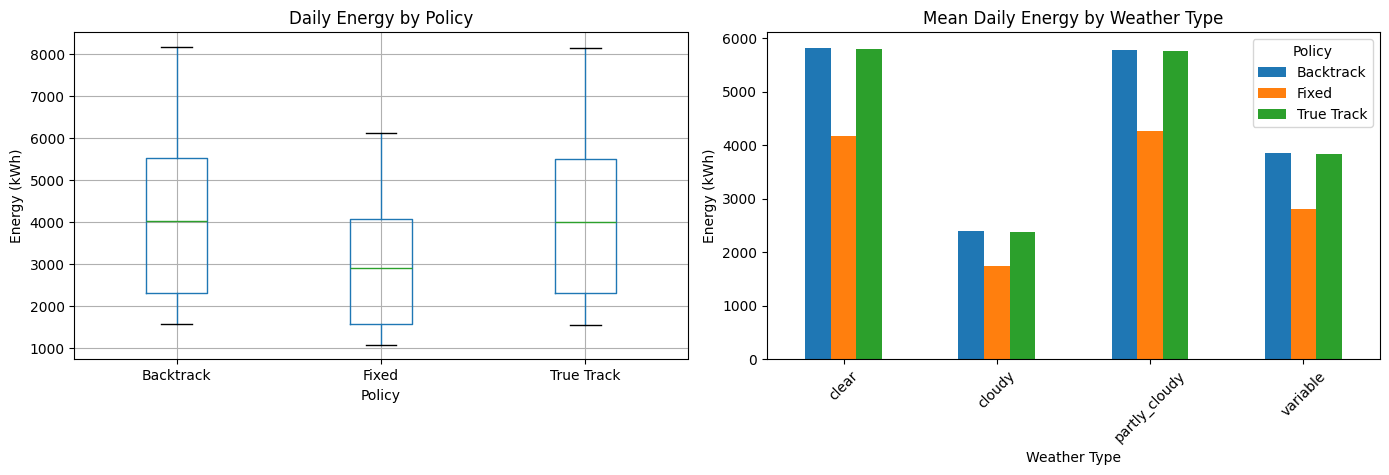

In [16]:
# Visualize multi-day results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot by policy
ax1 = axes[0]
policies_order = ['Fixed', 'True Track', 'Backtrack']
multi_day_results.boxplot(column='energy_kwh', by='policy', ax=ax1)
ax1.set_title('Daily Energy by Policy')
ax1.set_xlabel('Policy')
ax1.set_ylabel('Energy (kWh)')
plt.suptitle('')  # Remove automatic title

# Bar chart by weather
ax2 = axes[1]
weather_summary.plot(kind='bar', ax=ax2)
ax2.set_title('Mean Daily Energy by Weather Type')
ax2.set_xlabel('Weather Type')
ax2.set_ylabel('Energy (kWh)')
ax2.legend(title='Policy')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 9. Save Environment for Training

In [17]:
# Save environment code as module
env_code = '''
"""
Solar Tracker RL Environment

Gymnasium environment for training RL agents to control single-axis solar trackers.
"""

import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Any
from datetime import timedelta

import gymnasium as gym
from gymnasium import spaces

import pvlib
from pvlib import solarposition, irradiance, tracking, location, shading


@dataclass
class SiteConfig:
    """Configuration for a solar tracking installation."""
    name: str = "Solar Farm"
    latitude: float = 33.45
    longitude: float = -111.95
    altitude: float = 331
    timezone: str = "US/Arizona"
    gcr: float = 0.35
    axis_azimuth: float = 180
    max_angle: float = 60
    axis_height: float = 1.5
    collector_width: float = 2.2
    terrain_slope: float = 0
    slope_azimuth: float = 180
    capacity_kw: float = 1000
    module_efficiency: float = 0.20
    system_losses: float = 0.14
    temp_coefficient: float = -0.004
    
    @property
    def row_pitch(self) -> float:
        return self.collector_width / self.gcr
    
    @property
    def array_area(self) -> float:
        return self.capacity_kw * 1000 / (1000 * self.module_efficiency)


# Environment and supporting classes will be imported from this module
# Full implementation in notebook
'''

print("Environment module structure defined.")
print("\nFor training, import TrackerEnv and policies from this notebook or save as .py file.")

Environment module structure defined.

For training, import TrackerEnv and policies from this notebook or save as .py file.


## 10. Summary & Next Steps

### What We Built:
1. ✅ **WeatherGenerator** - Clear sky + synthetic clouds
2. ✅ **PowerModel** - POA → DC power with temperature/shading
3. ✅ **TrackerEnv** - Complete Gymnasium environment
4. ✅ **Baseline Policies** - Fixed, True Tracking, Backtracking, Random
5. ✅ **Comparison Framework** - Single and multi-day evaluation

### Key Findings:
- Geometric backtracking outperforms true tracking by ~X% (due to shading reduction)
- Fixed horizontal is significantly worse
- Performance gap varies by weather type
- **Opportunity**: RL agent can potentially learn when to deviate from backtracking

### Next Notebook (03_rl_training.ipynb):
- Train SAC/PPO agents
- Hyperparameter tuning
- Compare RL vs baselines
- Analyze learned policies

In [ ]:
print("\n" + "="*60)
print("  Notebook 2 Complete: Gymnasium Environment")
print("="*60)
print("\n🎯 Environment ready for RL training!")
print("\n🚀 Next: Notebook 3 - RL Agent Training")